# Helpers

In [1]:
import numpy as np 
import scipy.sparse as sps
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import scipy 
import os
import datetime
import argparse
from IPython.display import clear_output

In [2]:
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.utils.data import DataLoader
from torch.nn import functional as F
import copy
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 100 # default is 75
plt.style.use('default')
from tqdm import tqdm

In [3]:
from feature_maps import *

# Data

In [4]:
fname = "ground_data/butane_metad_nonaligned.npz" #butane_metad.npz DNMTBut.npz butane_hightemp.npz
inData = np.load(fname)
data_meta = inData["data"]
dataMetaD = data_meta
dihedralsMetaD = inData["dihedrals"] # the one dim dihedral angles
potentialMetaD = inData["potential"] # potential related to the particular data point
kbT_roomtemp = inData["kbT_roomtemp"]

In [5]:
data = dataMetaD[::10, :]
dihedrals = dihedralsMetaD[::10]
potentials = potentialMetaD[::10]
target_measure = np.exp(-potentials/(kbT_roomtemp))

## Load tmdmap

In [6]:
diff_data = np.load("diffusion_map_data.npz", allow_pickle=True)
diffcoords = diff_data['diffcoords'][:,:4]
L = diff_data['L']
eigvals = diff_data['eigvals']
Ltorch = torch.Tensor(L)
eigvals_mat = torch.Tensor(eigvals)[:4,:4]

In [7]:
size_vec = np.pi - np.abs(dihedrals - np.pi)
dihedrals_vec = np.abs(dihedrals - np.pi)

In [8]:
diffcoords.shape

(10000, 4)

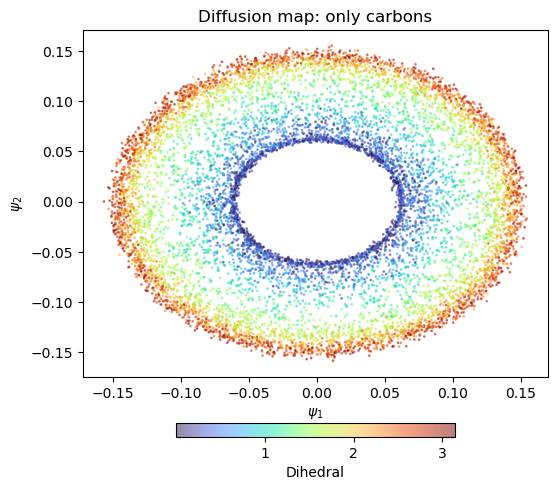

In [11]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
p = ax.scatter(diffcoords[:, 0], diffcoords[:, 1], \
               c=dihedrals_vec, cmap='turbo', s=1.0, alpha=0.5)
ax.set_xlabel(f"$\psi_1$")
ax.set_ylabel(f"$\psi_2$")
# ax.set_zlabel(f"$\psi_3$")
fig.colorbar(p,location='bottom', shrink=0.6, pad=0.1, label='Dihedral')
# ax.view_init(elev=30, azim=-150)
ax.set_title("Diffusion map: only carbons")
plt.show()

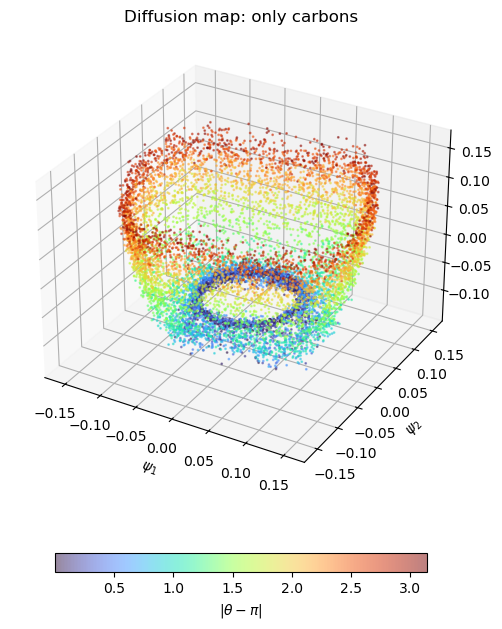

In [59]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
p = ax.scatter(diffcoords[:, 0], diffcoords[:, 1], diffcoords[:,2], \
               c=dihedrals_vec[::10], cmap='turbo', s=1.0, alpha=0.5)
ax.set_xlabel(f"$\psi_1$")
ax.set_ylabel(f"$\psi_2$")
# ax.set_zlabel(f"$\psi_3$")
fig.colorbar(p,location='bottom', shrink=0.6, pad=0.1, label=r'$|\theta - \pi|$')
# ax.view_init(elev=30, azim=-150)
ax.set_title("Diffusion map: only carbons")
plt.show()

# Learn Diffusion Net

## NN architectures

In [18]:
# setup featurizer
# feature_map = torch.vmap(compute_gram_matrix_recentered_torch)
layer = RecenterBondLayer(0, batch_mode=True)  # Enable batch mode
device = 'cpu'

In [19]:
from torch_models import *

In [44]:
# this defines the structure of the model

activation = nn.Tanh() 
input_dim = 12
hidden1_dim = 32
hidden2_dim = 32
hidden3_dim = 32
hidden4_dim = 32
encoder_dim = 3
output_dim = 12

# regular models:

# initializing the optimizer for the decoder
model_decoder_reg = Decoder(activation, input_dim, hidden1_dim, hidden2_dim, hidden3_dim, hidden4_dim, encoder_dim).to(device)
optimizer_reg_dec = optim.Adam(model_decoder_reg.parameters(), lr=1e-4, weight_decay = 1e-5)

# initializing the optimizer for the encoder
model_encoder_reg = Encoder(layer, activation, input_dim, hidden1_dim, hidden2_dim, hidden3_dim, hidden4_dim, encoder_dim).to(device)
optimizer_reg_enc = optim.Adam(model_encoder_reg.parameters(), lr = 1e-4, weight_decay=1e-5)

loss_function = nn.MSELoss()

## Datasets

In [27]:
# set up output data
out = diffcoords[:,:4]
outtorch = torch.from_numpy(out).float().T # converted our output from diff map to torch

# set up input data
train_data = torch.from_numpy(data).float() # converting the data to torch tensor
num_points = train_data.shape[0] 
gram_matrices_train = layer(train_data).T
print(train_data.shape)

torch.Size([10000, 12])


In [28]:
np.random.seed(10)
torch.manual_seed(10)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")
dim = 4 # dimension of the output layer of the NN
train = True

Using cpu device


In [29]:
regular_data = DNetDataset(train_data, outtorch.T[:, :4], gram_matrices_train.T)
train_loader = torch.utils.data.DataLoader(regular_data, batch_size=128, shuffle=True)

## Training loop

In [31]:
mse_loss = torch.nn.MSELoss()

In [33]:
lag = 10 # defining the lag for the time-lagged autoencoder
batch_size = 64 
num_epochs = 1
train = True
if train:
    for epoch in tqdm(range(num_epochs)):
        # print(f"epoch {epoch}:")
        if epoch % 50 == 0:
            train_sep(model_encoder_reg, model_decoder_reg, optimizer_reg_enc, optimizer_reg_dec, device, Ltorch, eigvals_mat, train_loader, mse_loss, True)
        else: 
            train_sep(model_encoder_reg, model_decoder_reg, optimizer_reg_enc, optimizer_reg_dec, device, Ltorch, eigvals_mat, train_loader, mse_loss, False)

100%|██████████| 1/1 [00:02<00:00,  2.04s/it]

====> Average loss: 0.3570, 0.0000, 0.3570
====> Average decoder loss: 0.0055


# Test the diffusion net 

In [45]:
loader = True
if loader: 
    model_encoder_reg = Encoder(layer, activation, input_dim, hidden1_dim, hidden2_dim, hidden3_dim, hidden4_dim, encoder_dim).to(device)
    model_encoder_reg.load_state_dict(torch.load("diffusion_net", map_location=device))
model_encoder_reg.eval()

Encoder(
  (featurizer): RecenterBondLayer()
  (activation): Tanh()
  (hidden1): Linear(in_features=12, out_features=32, bias=True)
  (hidden2): Linear(in_features=32, out_features=32, bias=True)
  (hidden3): Linear(in_features=32, out_features=32, bias=True)
  (hidden4): Linear(in_features=32, out_features=32, bias=True)
  (bottleneck): Linear(in_features=32, out_features=3, bias=True)
  (encoder): Sequential(
    (0): Linear(in_features=12, out_features=32, bias=True)
    (1): Tanh()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Tanh()
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): Tanh()
    (6): Linear(in_features=32, out_features=32, bias=True)
    (7): Tanh()
    (8): Linear(in_features=32, out_features=3, bias=True)
    (9): Tanh()
  )
)

In [46]:
# construct testing set 
num_points_test = dataMetaD.shape[0]
test_data = torch.Tensor(dataMetaD.reshape((num_points_test, 12)))
gram_matrices_test = test_data

In [47]:
encoded_out_nontl = model_encoder_reg(gram_matrices_train.T.float()).detach().cpu().numpy()
encoded_out_test_nontl = model_encoder_reg(gram_matrices_test.to(device).float()).detach().numpy()
reconst_out_nontl = model_decoder_reg(encoded_out_nontl).T.detach()

In [49]:
size_vec = np.pi - np.abs(dihedralsMetaD-np.pi)
dihedrals_vec = np.abs(dihedralsMetaD - np.pi)
test_indices = ~np.zeros(encoded_out_test_nontl.shape[0],dtype=bool)
test_indices[::10] = False

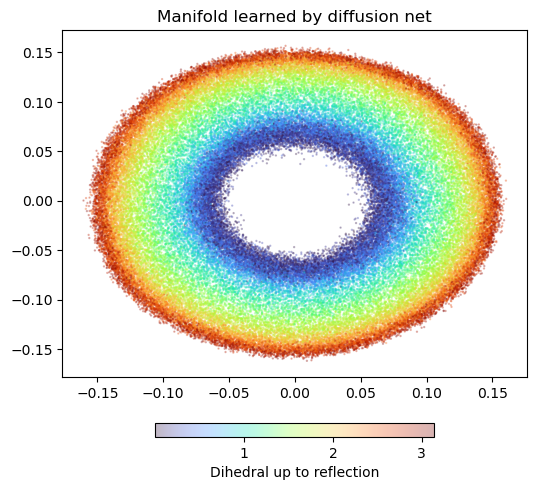

In [52]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
p = ax.scatter(encoded_out_test_nontl[test_indices, 0], encoded_out_test_nontl[test_indices, 1], \
               c=dihedrals_vec[test_indices], cmap='turbo', s=0.5, alpha=0.3)
ax.set_title("Manifold learned by diffusion net")
# ax.view_init(elev=50, azim=120, roll=0)
fig.colorbar(p,location='bottom', shrink=0.6, pad=0.1, label='Dihedral up to reflection')

(10000, 3)


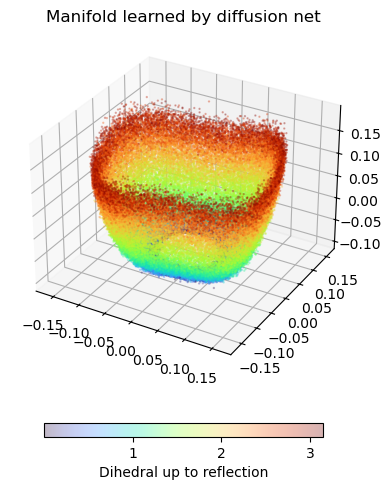

In [55]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(projection='3d')
p = ax.scatter(encoded_out_test_nontl[test_indices, 0], encoded_out_test_nontl[test_indices, 1], encoded_out_test_nontl[test_indices, 2],\
               c=dihedrals_vec[test_indices], cmap='turbo', s=0.5, alpha=0.3)
ax.set_title("Manifold learned by diffusion net")
fig.colorbar(p,location='bottom', shrink=0.6, pad=0.1, label='Dihedral up to reflection')

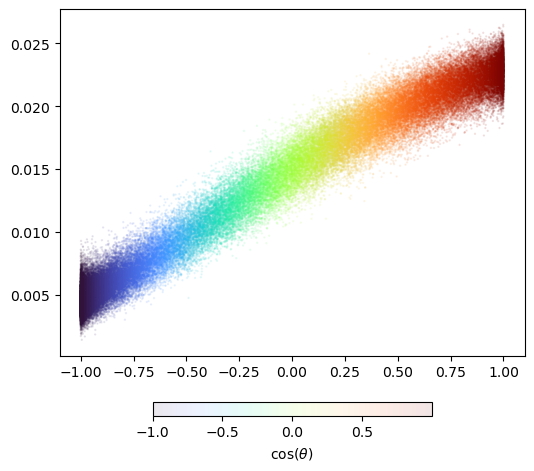

In [66]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
p = ax.scatter(np.cos(dihedralsMetaD)[test_indices], encoded_out_test_nontl[test_indices, 0]**2 + encoded_out_test_nontl[test_indices, 1]**2, \
               c=np.cos(dihedralsMetaD)[test_indices], cmap='turbo', s=0.5, alpha=0.1)
# ax.set_title("Manifold learned by diffusion net")
fig.colorbar(p,location='bottom', shrink=0.6, pad=0.1, label=r'$\cos(\theta)$')

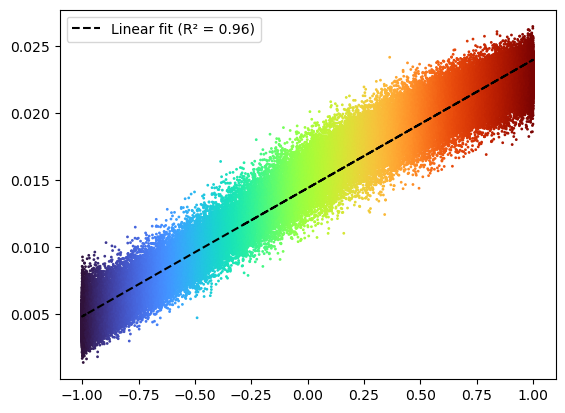

In [70]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
x = np.cos(dihedralsMetaD)[test_indices]
y = encoded_out_test_nontl[test_indices, 0]**2 + encoded_out_test_nontl[test_indices, 1]**2
x_reshaped = x.reshape(-1, 1)
model = LinearRegression()
model.fit(x_reshaped, y)
y_pred = model.predict(x_reshaped)
r2 = r2_score(y, y_pred)

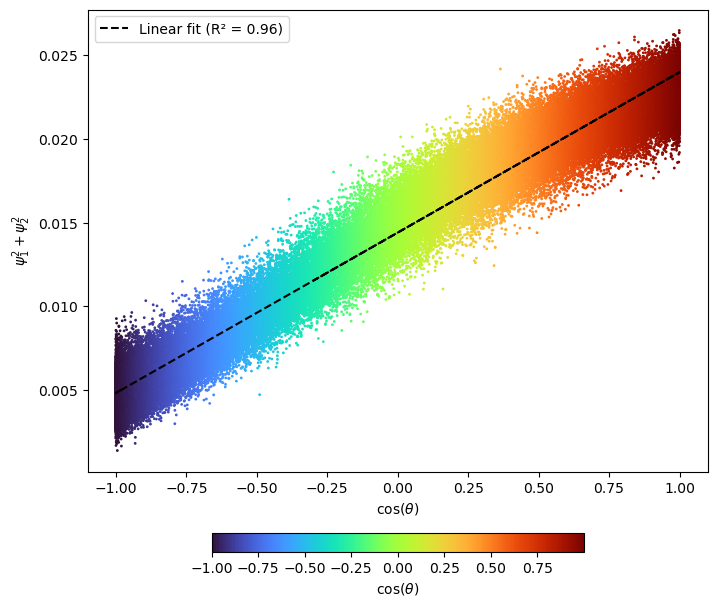

In [75]:
# Plot
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
p = ax.scatter(x, y, c=x, s=1.0, cmap='turbo')
ax.plot(x, y_pred, 'k--', label=f'Linear fit (R² = {r2:.2f})')
ax.set_xlabel(r'$\cos(\theta)$')
ax.set_ylabel(r'$\psi_{1}^{2} + \psi_{2}^{2}$')
ax.legend()
fig.colorbar(p,location='bottom', shrink=0.6, pad=0.1, label=r'$\cos(\theta)$')